In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [4]:
# НОРМАЛИЗАЦИЯ ДАННЫХ

class ZScoreNormalizer:
    """Z-score нормализация (стандартизация)"""
    
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, X):
        return (X - self.mean) / (self.std + 1e-8)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    

class MinMaxNormalizer:
    """Min-Max нормализация [0, 1]"""
    
    def __init__(self):
        self.min = None
        self.max = None
    
    def fit(self, X):
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)
        return self
    
    def transform(self, X):
        return (X - self.min) / (self.max - self.min + 1e-8)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [9]:
# МЕТРИКИ

def mse(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred) ** 2)


def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))


def r2(y_true, y_pred):
    """R² Score (Coefficient of Determination)"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / (ss_tot + 1e-8))


def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100



In [5]:
# ЛИНЕЙНАЯ РЕГРЕССИЯ
class CustomLinearRegression:
    """Линейная регрессия с тремя методами обучения"""
    
    def __init__(self, fit_method='analytical', learning_rate=0.01, epochs=1000, batch_size=32):
        self.fit_method = fit_method
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.losses = []
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        
        if self.fit_method == 'analytical':
            self._fit_analytical(X, y)
        elif self.fit_method == 'gd':
            self._fit_gd(X, y)
        elif self.fit_method == 'sgd':
            self._fit_sgd(X, y)
        else:
            raise ValueError(f"Unknown fit_method: {self.fit_method}")
        
        return self
    
    def _fit_analytical(self, X, y):
        """Аналитическое решение: w = (X^T * X)^-1 * X^T * y"""
        X_with_bias = np.column_stack([np.ones(len(X)), X])
        coefficients = np.linalg.lstsq(X_with_bias, y, rcond=None)[0]
        self.bias = coefficients[0]
        self.weights = coefficients[1:]
    
    def _fit_gd(self, X, y):
        """Градиентный спуск"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []
        
        for epoch in range(self.epochs):
            y_pred = X.dot(self.weights) + self.bias
            error = y_pred - y
            
            dw = (2 / n_samples) * X.T.dot(error)
            db = (2 / n_samples) * np.sum(error)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            loss = np.mean(error ** 2)
            self.losses.append(loss)
    
    def _fit_sgd(self, X, y):
        """Стохастический градиентный спуск"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                
                y_pred = X_batch.dot(self.weights) + self.bias
                error = y_pred - y_batch
                
                dw = (2 / len(X_batch)) * X_batch.T.dot(error)
                db = (2 / len(X_batch)) * np.sum(error)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                epoch_loss += np.mean(error ** 2) * len(X_batch)
            
            self.losses.append(epoch_loss / n_samples)
    
    def predict(self, X):
        X = np.asarray(X)
        return X.dot(self.weights) + self.bias



In [6]:
# КРОСС-ВАЛИДАЦИЯ

class KFoldCV:
    """K-Fold Cross-Validation"""
    
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def split(self, X, y):
        n_samples = len(X)
        indices = np.arange(n_samples)
        
        if self.shuffle:
            np.random.RandomState(self.random_state).shuffle(indices)
        
        fold_size = n_samples // self.n_splits
        
        for fold in range(self.n_splits):
            start = fold * fold_size
            end = start + fold_size if fold != self.n_splits - 1 else n_samples
            
            test_idx = indices[start:end]
            train_idx = np.concatenate([indices[:start], indices[end:]])
            
            yield train_idx, test_idx
    
    def cross_val_score(self, model, X, y, metric='mse'):
        scores = []
        
        for train_idx, test_idx in self.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model_copy = CustomLinearRegression(
                fit_method=model.fit_method,
                learning_rate=model.learning_rate,
                epochs=model.epochs,
                batch_size=model.batch_size
            )
            
            model_copy.fit(X_train, y_train)
            y_pred = model_copy.predict(X_test)
            
            if metric == 'mse':
                score = mse(y_test, y_pred)
            elif metric == 'mae':
                score = mae(y_test, y_pred)
            elif metric == 'r2':
                score = r2(y_test, y_pred)
            elif metric == 'mape':
                score = mape(y_test, y_pred)
            else:
                raise ValueError(f"Unknown metric: {metric}")
            
            scores.append(score)
        
        return np.array(scores)


class LeaveOneOutCV:
    """Leave-One-Out Cross-Validation"""
    
    def split(self, X, y):
        n_samples = len(X)
        
        for i in range(n_samples):
            test_idx = np.array([i])
            train_idx = np.concatenate([np.arange(i), np.arange(i + 1, n_samples)])
            
            yield train_idx, test_idx
    
    def cross_val_score(self, model, X, y, metric='mse'):
        scores = []
        
        for train_idx, test_idx in self.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model_copy = CustomLinearRegression(
                fit_method=model.fit_method,
                learning_rate=model.learning_rate,
                epochs=model.epochs,
                batch_size=model.batch_size
            )
            
            model_copy.fit(X_train, y_train)
            y_pred = model_copy.predict(X_test)
            
            if metric == 'mse':
                score = mse(y_test, y_pred)
            elif metric == 'mae':
                score = mae(y_test, y_pred)
            elif metric == 'r2':
                score = r2(y_test, y_pred)
            elif metric == 'mape':
                score = mape(y_test, y_pred)
            else:
                raise ValueError(f"Unknown metric: {metric}")
            
            scores.append(score)
        
        return np.array(scores)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print("="*70)
print(f"Train: {train.shape}, Test: {test.shape}")
print(f"RiskScore: Mean={train['RiskScore'].mean():.2f}, Median={train['RiskScore'].median():.2f}")
print(f"           Min={train['RiskScore'].min():.2f}, Max={train['RiskScore'].max():.2f}")
print("="*70)

Train: (11017, 35), Test: (5000, 35)
RiskScore: Mean=-25698.78, Median=44.12
           Min=-9999999.00, Max=10000000.00


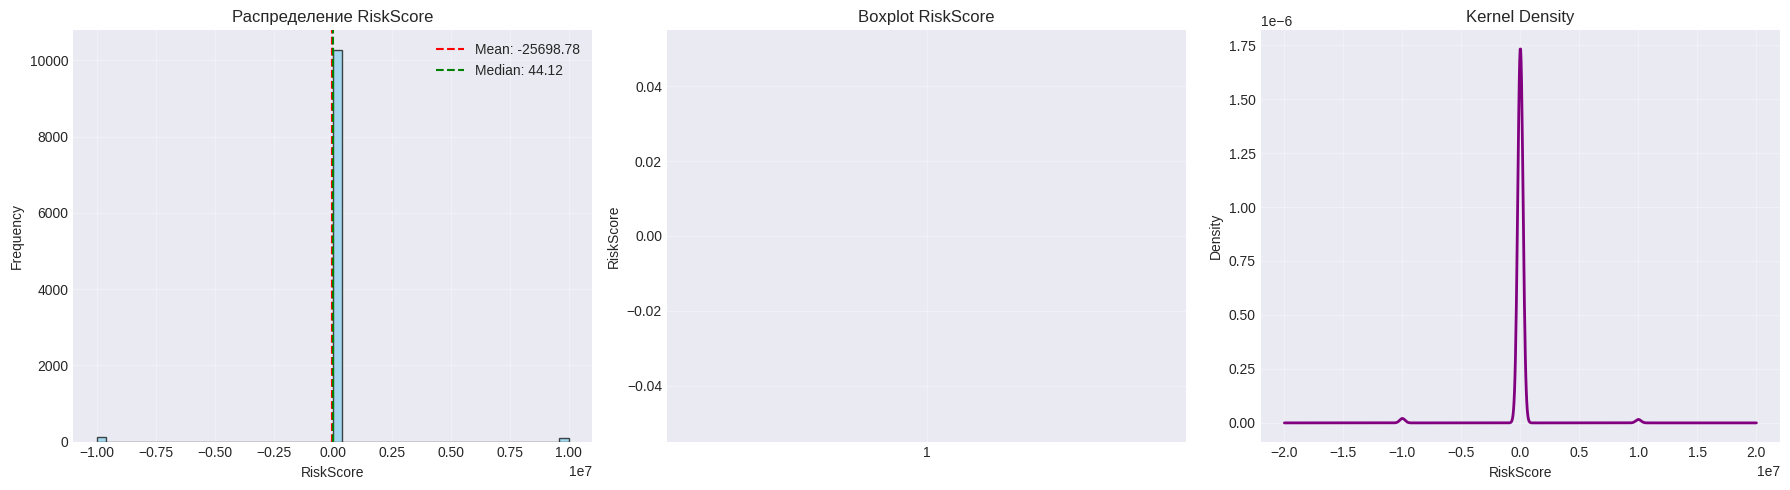

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(train['RiskScore'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(train['RiskScore'].mean(), color='red', linestyle='--', label=f'Mean: {train["RiskScore"].mean():.2f}')
axes[0].axvline(train['RiskScore'].median(), color='green', linestyle='--', label=f'Median: {train["RiskScore"].median():.2f}')
axes[0].set_xlabel('RiskScore')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Распределение RiskScore')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(train['RiskScore'], vert=True)
axes[1].set_ylabel('RiskScore')
axes[1].set_title('Boxplot RiskScore')
axes[1].grid(True, alpha=0.3)

train['RiskScore'].plot(kind='kde', ax=axes[2], color='purple', linewidth=2)
axes[2].set_xlabel('RiskScore')
axes[2].set_title('Kernel Density')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'RiskScore' in numeric_cols:
    numeric_cols.remove('RiskScore')

correlations = train[numeric_cols + ['RiskScore']].corr()['RiskScore'].drop('RiskScore').sort_values(ascending=False)

print("Топ-20 корреляций с RiskScore:")
print(correlations.head(20))

Топ-20 корреляций с RiskScore:
PaymentHistory               0.019144
TotalDebtToIncomeRatio       0.013879
MonthlyLoanPayment           0.012366
LoanAmount                   0.011771
NumberOfCreditInquiries      0.011055
NetWorth                     0.008804
TotalAssets                  0.008092
SavingsAccountBalance        0.007611
CreditCardUtilizationRate    0.005501
BankruptcyHistory            0.005184
JobTenure                    0.003822
InterestRate                 0.003388
CreditScore                  0.002383
BaseInterestRate             0.002081
NumberOfOpenCreditLines      0.000730
CheckingAccountBalance      -0.000648
MonthlyDebtPayments         -0.001871
LoanDuration                -0.001880
Age                         -0.004648
TotalLiabilities            -0.004976
Name: RiskScore, dtype: float64


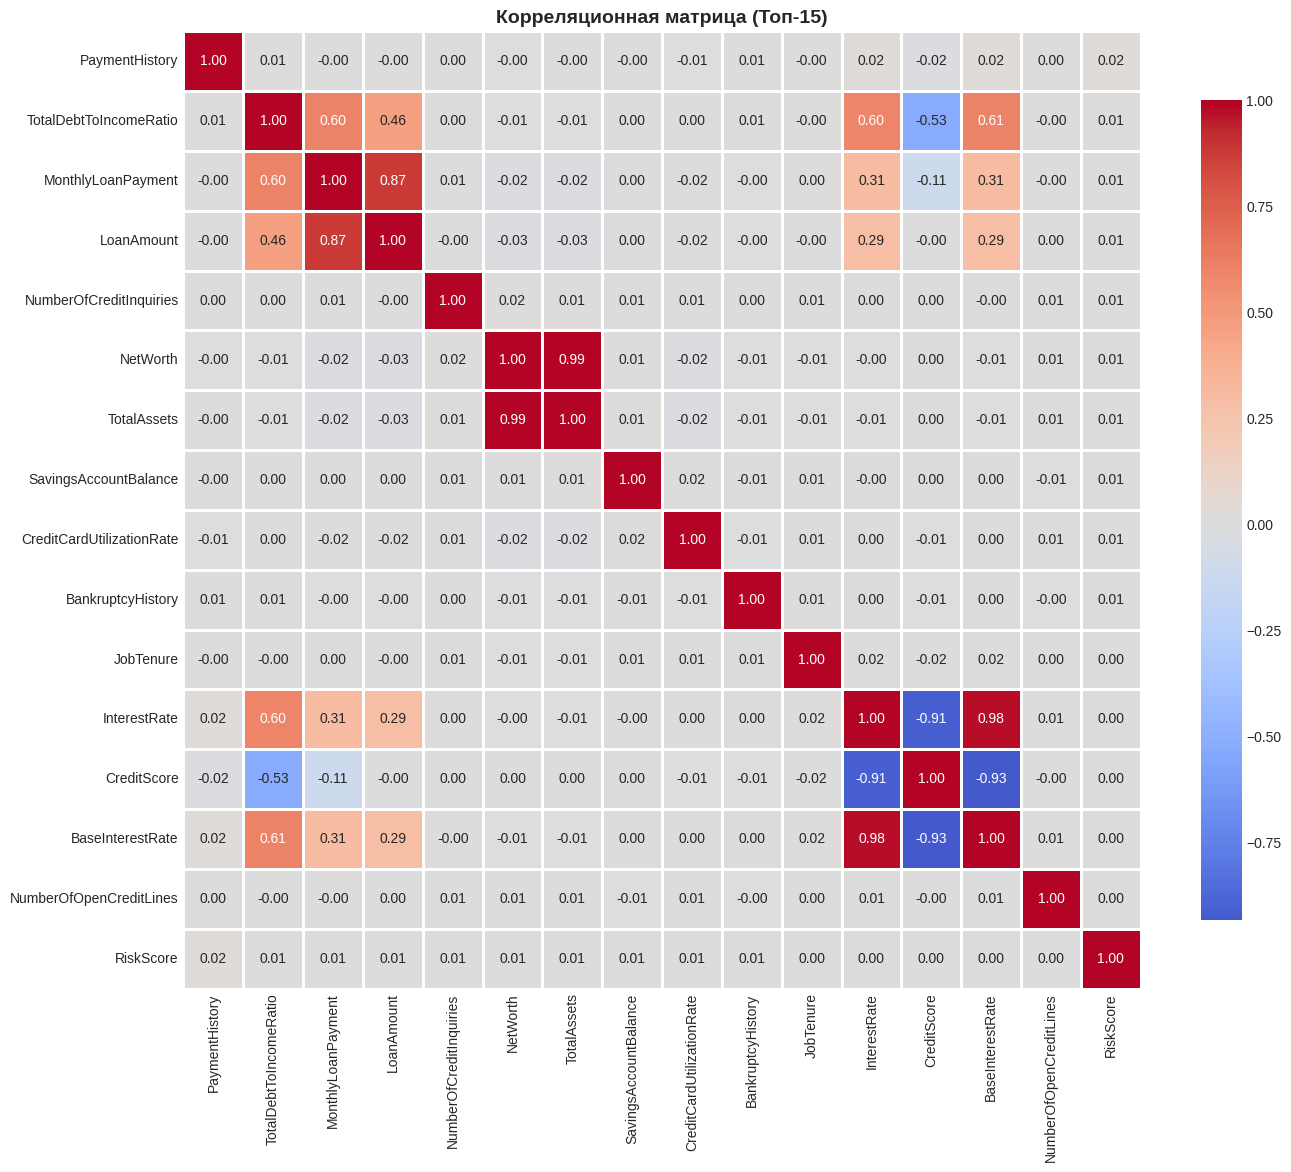

In [5]:
top_features = correlations.abs().head(15).index.tolist()
corr_matrix = train[top_features + ['RiskScore']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица (Топ-15)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

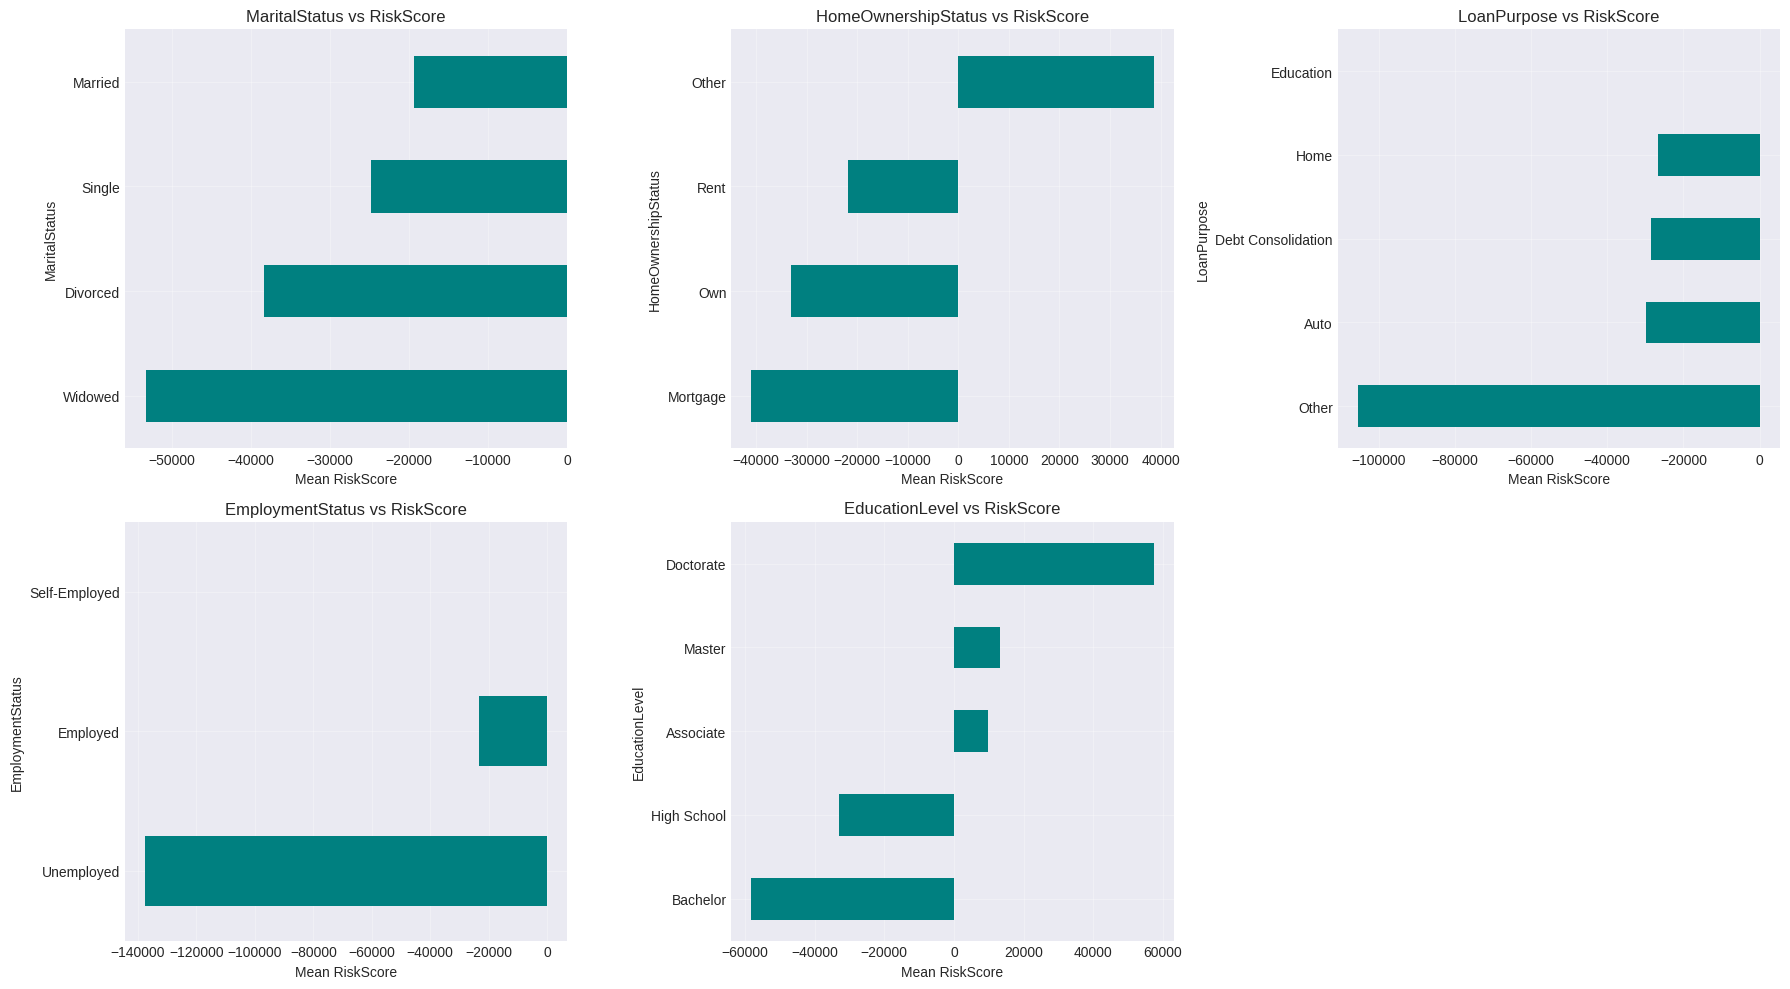

In [6]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 
                   'EmploymentStatus', 'EducationLevel']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    train.groupby(col)['RiskScore'].mean().sort_values().plot(kind='barh', ax=axes[idx], color='teal')
    axes[idx].set_xlabel('Mean RiskScore')
    axes[idx].set_title(f'{col} vs RiskScore')
    axes[idx].grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

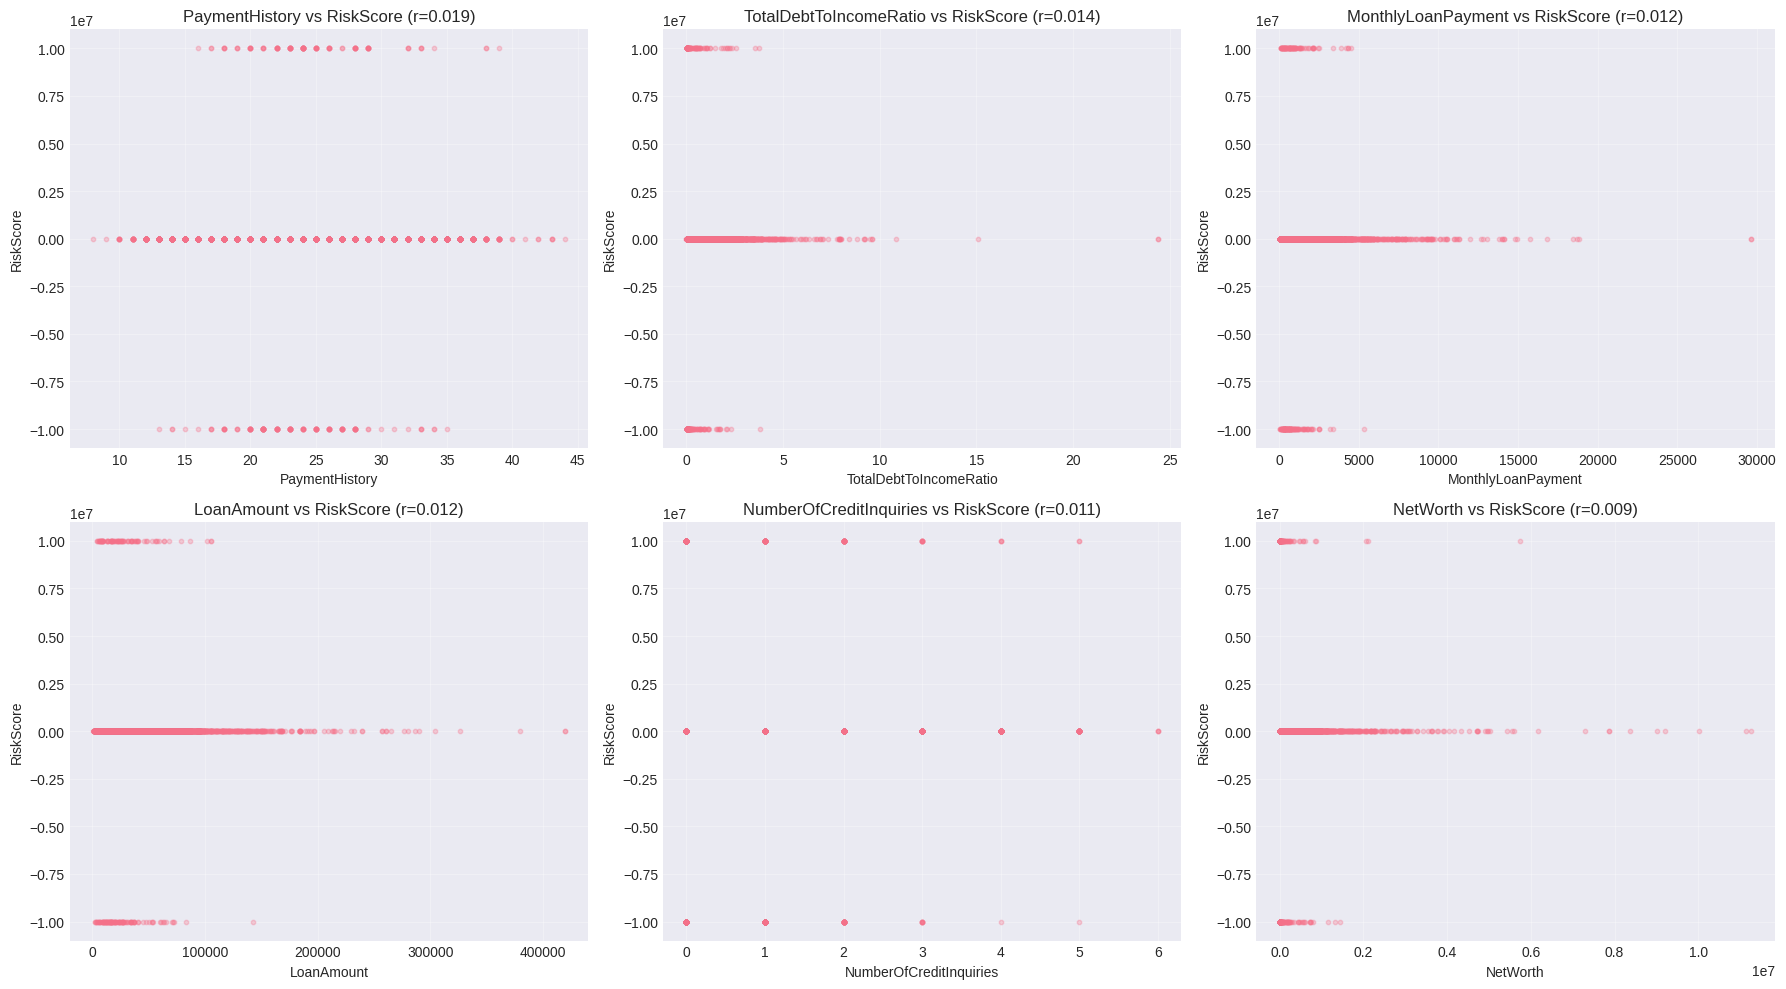

In [7]:
top_6_features = correlations.abs().head(6).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    axes[idx].scatter(train[feature], train['RiskScore'], alpha=0.3, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('RiskScore')
    axes[idx].set_title(f'{feature} vs RiskScore (r={correlations[feature]:.3f})')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
def advanced_preprocess_data(train_df, test_df):
    df = train_df.copy()
    test_df_proc = test_df.copy()
    
    drop_cols = ['AnnualIncome', 'NetWorth', 'Experience', 'InterestRate', 
                 'ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
    
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    test_df_proc = test_df_proc.drop(columns=[c for c in drop_cols if c in test_df_proc.columns and c != 'ID'])
    
    y = df['RiskScore'].copy()
    mask_not_null = y.notna()
    df = df[mask_not_null]
    y = y[mask_not_null]
    
    Q1, Q3 = y.quantile(0.25), y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outlier_mask = (y >= lower_bound) & (y <= upper_bound)
    df = df[outlier_mask]
    y = y[outlier_mask]
    
    X = df.drop(columns=['RiskScore'])
    
    def create_features(data):
        d = data.copy()
        
        if 'BankruptcyHistory' in d.columns:
            d['HasBankruptcy'] = (d['BankruptcyHistory'] > 0).astype(int)
            d['BankruptcyHistory_log'] = np.log1p(d['BankruptcyHistory'])
        
        if 'PreviousLoanDefaults' in d.columns:
            d['HasDefaults'] = (d['PreviousLoanDefaults'] > 0).astype(int)
            d['PreviousLoanDefaults_log'] = np.log1p(d['PreviousLoanDefaults'])
        
        log_features = ['MonthlyIncome', 'LoanAmount', 'MonthlyDebtPayments']
        for col in log_features:
            if col in d.columns:
                d[f'{col}_log'] = np.log1p(d[col].clip(lower=0))
        
        if 'CreditScore' in d.columns:
            d['CreditScore_sq'] = d['CreditScore'] ** 2
            d['CreditScore_cubed'] = d['CreditScore'] ** 3
        
        if 'Age' in d.columns:
            d['Age_sq'] = d['Age'] ** 2
            d['Age_cubed'] = d['Age'] ** 3
        
        if 'MonthlyIncome' in d.columns:
            d['MonthlyIncome_sq'] = d['MonthlyIncome'] ** 2
            d['MonthlyIncome_cubed'] = d['MonthlyIncome'] ** 3
        
        sqrt_features = ['TotalDebtToIncomeRatio', 'LoanAmount', 'Age']
        for col in sqrt_features:
            if col in d.columns:
                d[f'{col}_sqrt'] = np.sqrt(d[col].clip(lower=0))
        
        if 'TotalAssets' in d.columns and 'NumberOfDependents' in d.columns:
            d['AssetPerDependent'] = d['TotalAssets'] / (d['NumberOfDependents'] + 1)
        
        if 'CreditCardUtilizationRate' in d.columns and 'NumberOfOpenCreditLines' in d.columns:
            d['UtilizationPerLine'] = d['CreditCardUtilizationRate'] / (d['NumberOfOpenCreditLines'] + 1)
        
        if 'LoanAmount' in d.columns and 'LoanDuration' in d.columns:
            d['MonthlyLoanPayment_calc'] = d['LoanAmount'] / (d['LoanDuration'] + 1)
        
        interactions = [
            ('Age', 'MonthlyIncome', 'Age_x_Income'),
            ('CreditScore', 'PaymentHistory', 'Credit_x_Payment'),
            ('NumberOfDependents', 'MonthlyIncome', 'Dependents_x_Income'),
            ('CreditScore', 'LoanAmount', 'Credit_x_Loan'),
            ('Age', 'CreditScore', 'Age_x_Credit'),
            ('LoanDuration', 'LoanAmount', 'Duration_x_Loan'),
            ('CreditScore', 'MonthlyIncome', 'CreditScore_x_Income'),
            ('CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'CreditUtilization_x_Lines'),
            ('NumberOfCreditInquiries', 'CreditScore', 'CreditInquiries_x_CreditScore'),
            ('BaseInterestRate', 'LoanAmount', 'InterestRate_x_LoanAmount'),
            ('TotalAssets', 'MonthlyIncome', 'Assets_x_Income'),
            ('PaymentHistory', 'MonthlyIncome', 'PaymentHistory_x_Income'),
            ('TotalDebtToIncomeRatio', 'CreditScore', 'DebtRatio_x_CreditScore'),
            ('LengthOfCreditHistory', 'CreditScore', 'CreditHistory_x_Score'),
            ('BaseInterestRate', 'CreditScore', 'InterestRate_x_CreditScore'),
            ('TotalLiabilities', 'MonthlyIncome', 'Liabilities_x_Income')
        ]
        
        for col1, col2, name in interactions:
            if col1 in d.columns and col2 in d.columns:
                d[name] = d[col1] * d[col2]
        
        if 'LoanAmount' in d.columns and 'MonthlyIncome' in d.columns:
            d['LoanToIncome'] = d['LoanAmount'] / (d['MonthlyIncome'] * 12 + 1)
        
        if 'SavingsAccountBalance' in d.columns and 'MonthlyIncome' in d.columns:
            d['SavingsToIncome'] = d['SavingsAccountBalance'] / (d['MonthlyIncome'] * 12 + 1)
        
        if 'CheckingAccountBalance' in d.columns and 'MonthlyIncome' in d.columns:
            d['CheckingToIncome'] = d['CheckingAccountBalance'] / (d['MonthlyIncome'] * 12 + 1)
        
        if 'TotalLiabilities' in d.columns and 'TotalAssets' in d.columns:
            d['DebtToAssetRatio'] = d['TotalLiabilities'] / (d['TotalAssets'] + 1)
        
        if 'LoanAmount' in d.columns and 'TotalAssets' in d.columns:
            d['LoanToAssetRatio'] = d['LoanAmount'] / (d['TotalAssets'] + 1)
        
        if 'MonthlyDebtPayments' in d.columns and 'MonthlyIncome' in d.columns:
            d['DebtPaymentToIncome'] = d['MonthlyDebtPayments'] / (d['MonthlyIncome'] + 1)
        
        if 'CreditScore' in d.columns and 'NumberOfOpenCreditLines' in d.columns:
            d['CreditPerLine'] = d['CreditScore'] / (d['NumberOfOpenCreditLines'] + 1)
        
        return d
    
    X = create_features(X)
    test_df_proc = create_features(test_df_proc)
    
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_glog = [c for c in num_cols if not c.endswith('_log') 
                    and not c.endswith('_sq') and not c.endswith('_sqrt') 
                    and not c.endswith('_cubed')]
    
    for col in cols_to_glog:
        X[f'{col}_glog'] = np.log1p(X[col].clip(lower=0))
        if col in test_df_proc.columns:
            test_df_proc[f'{col}_glog'] = np.log1p(test_df_proc[col].clip(lower=0))
    
    cat_cols = ['EmploymentStatus', 'EducationLevel']
    
    for col in cat_cols:
        if col in X.columns:
            dummies_train = pd.get_dummies(X[col], prefix=col, drop_first=True)
            X = pd.concat([X.drop(columns=[col]), dummies_train], axis=1)
            
            if col in test_df_proc.columns:
                dummies_test = pd.get_dummies(test_df_proc[col], prefix=col, drop_first=True)
                test_df_proc = pd.concat([test_df_proc.drop(columns=[col]), dummies_test], axis=1)
                
                for c in dummies_train.columns:
                    if c not in dummies_test.columns:
                        test_df_proc[c] = 0
    
    test_ids = None
    if 'ID' in test_df_proc.columns:
        test_ids = test_df_proc['ID'].copy()
        test_df_proc = test_df_proc.drop(columns=['ID'])
    
    for col in X.columns:
        if col not in test_df_proc.columns:
            test_df_proc[col] = 0
    test_df_proc = test_df_proc[X.columns]
    
    for col in X.select_dtypes(include=[np.number]).columns:
        if not col.endswith('_glog'):
            q01 = X[col].quantile(0.01)
            q99 = X[col].quantile(0.99)
            X[col] = X[col].clip(lower=q01, upper=q99)
            test_df_proc[col] = test_df_proc[col].clip(lower=q01, upper=q99)
    
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    test_df_imputed = pd.DataFrame(imputer.transform(test_df_proc), 
                                   columns=test_df_proc.columns, index=test_df_proc.index)
    
    var_threshold = VarianceThreshold(threshold=0.01)
    var_threshold.fit(X_imputed)
    
    low_var_features = X_imputed.columns[~var_threshold.get_support()].tolist()
    if low_var_features:
        X_imputed = X_imputed.drop(columns=low_var_features)
        test_df_imputed = test_df_imputed.drop(columns=[c for c in low_var_features 
                                                         if c in test_df_imputed.columns])
    
    print(f"Обработка завершена: X={X_imputed.shape}, y={y.shape}, X_test={test_df_imputed.shape}")
    
    return X_imputed, y, test_df_imputed, test_ids

X_processed, y_processed, X_test_processed, test_ids = advanced_preprocess_data(train, test)

Обработка завершена: X=(10272, 117), y=(10272,), X_test=(5000, 117)


In [38]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_processed), columns=X_processed.columns, index=X_processed.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_processed), columns=X_test_processed.columns, index=X_test_processed.index)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_processed, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (8217, 117), Val: (2055, 117)


In [39]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_train_pred_lr = model_lr.predict(X_train)
y_val_pred_lr = model_lr.predict(X_val)

train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
val_mse_lr = mean_squared_error(y_val, y_val_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
val_r2_lr = r2_score(y_val, y_val_pred_lr)

print(f"Train MSE: {train_mse_lr:.4f}, R²: {train_r2_lr:.4f}")
print(f"Val   MSE: {val_mse_lr:.4f}, R²: {val_r2_lr:.4f}")

cv_scores_lr = cross_val_score(
    LinearRegression(), X_scaled, y_processed, 
    cv=5, scoring='neg_mean_squared_error'
)

cv_mse_lr = -cv_scores_lr.mean()
cv_std_lr = cv_scores_lr.std()

print(f"LinearRegression CV MSE: {cv_mse_lr:.4f} (±{cv_std_lr:.4f})")

Train MSE: 27.5424, R²: 0.9072
Val   MSE: 29.5551, R²: 0.9012
LinearRegression CV MSE: 28.6194 (±0.3886)
LinearRegression CV MSE: 28.6194 (±0.3886)


In [40]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, y_processed)

print(f"Лучший alpha: {ridge_cv.alpha_}")

model_ridge = Ridge(alpha=ridge_cv.alpha_)
model_ridge.fit(X_train, y_train)

y_val_pred_ridge = model_ridge.predict(X_val)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)

print(f"Val MSE: {val_mse_ridge:.4f}, R²: {val_r2_ridge:.4f}")

cv_scores_ridge = cross_val_score(
    Ridge(alpha=ridge_cv.alpha_), X_scaled, y_processed,
    cv=5, scoring='neg_mean_squared_error'
)
cv_mse_ridge = -cv_scores_ridge.mean()
cv_std_ridge = cv_scores_ridge.std()

print(f"Ridge CV MSE: {cv_mse_ridge:.4f} (±{cv_std_ridge:.4f})")

results_df = pd.DataFrame({
    'Model': ['LinearRegression', 'Ridge'],
    'Val MSE': [val_mse_lr, val_mse_ridge],
    'CV MSE': [cv_mse_lr, cv_mse_ridge],
    'CV Std': [cv_std_lr, cv_std_ridge]
})

print(results_df.to_string(index=False))

best_model_idx = results_df['CV MSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_cv_mse = results_df.loc[best_model_idx, 'CV MSE']

print(f"Лучшая модель: {best_model_name}")
print(f"MSE: {best_cv_mse:.4f}")

Лучший alpha: 0.001
Val MSE: 29.7692, R²: 0.9005
Ridge CV MSE: 28.7555 (±0.3835)
           Model   Val MSE    CV MSE   CV Std
LinearRegression 29.555104 28.619358 0.388619
           Ridge 29.769209 28.755474 0.383492
Лучшая модель: LinearRegression
MSE: 28.6194


In [41]:
sample_size = min(5000, len(X_scaled))
X_sample = X_scaled.sample(n=sample_size, random_state=42)
y_sample = y_processed.loc[X_sample.index]

mi_scores = mutual_info_regression(X_sample, y_sample, random_state=42)

mi_df = pd.DataFrame({
    'feature': X_scaled.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

low_mi_threshold = 0.001
high_mi_features = mi_df[mi_df['mi_score'] >= low_mi_threshold]['feature'].tolist()

X_scaled_filtered = X_scaled[high_mi_features]
X_test_scaled_filtered = X_test_scaled[high_mi_features]

print(f"Признаков с MI >= {low_mi_threshold}: {len(high_mi_features)}")

Признаков с MI >= 0.001: 112


In [43]:
k_values = [30, 40, 50, 60, 70, 80]
best_k = None
best_k_mse = float('inf')

for k in k_values:
    k_actual = min(k, X_scaled_filtered.shape[1])
    
    selector = SelectKBest(f_regression, k=k_actual)
    X_selected = selector.fit_transform(X_scaled_filtered, y_processed)
    
    cv_scores = cross_val_score(
        Ridge(alpha=ridge_cv.alpha_), 
        X_selected, 
        y_processed,
        cv=5, 
        scoring='neg_mean_squared_error'
    )
    
    cv_mse = -cv_scores.mean()
    
    if cv_mse < best_k_mse:
        best_k_mse = cv_mse
        best_k = k_actual
    
    print(f"k={k_actual:3d} | CV MSE={cv_mse:.4f}")

print()
print(f"Лучшее k: {best_k} | MSE: {best_k_mse:.4f}")

selector_best = SelectKBest(f_regression, k=best_k)
X_selected_best = selector_best.fit_transform(X_scaled_filtered, y_processed)
X_test_selected_best = selector_best.transform(X_test_scaled_filtered)

k= 30 | CV MSE=50.6613
k= 40 | CV MSE=48.8699
k= 50 | CV MSE=39.2548
k= 60 | CV MSE=31.5873
k= 70 | CV MSE=31.3107
k= 80 | CV MSE=29.8896

Лучшее k: 80 | MSE: 29.8896
k= 80 | CV MSE=29.8896

Лучшее k: 80 | MSE: 29.8896


In [44]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_selected_best)
X_test_poly = poly.transform(X_test_selected_best)

print(f"После полиномов: {X_poly.shape[1]} признаков")

scaler_poly = StandardScaler()
X_poly_scaled = scaler_poly.fit_transform(X_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

alphas_poly = [0.1, 0.5, 1, 5, 10, 50, 100, 200, 500, 1000]
best_alpha_poly = None
best_mse_poly = float('inf')

for alpha in alphas_poly:
    cv_scores = cross_val_score(
        Ridge(alpha=alpha),
        X_poly_scaled,
        y_processed,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    
    cv_mse = -cv_scores.mean()
    
    if cv_mse < best_mse_poly:
        best_mse_poly = cv_mse
        best_alpha_poly = alpha
    
    print(f"Alpha={alpha:>6} | CV MSE={cv_mse:.4f}")

print()
print(f"Лучший alpha: {best_alpha_poly} | MSE: {best_mse_poly:.4f}")



После полиномов: 3320 признаков
Alpha=   0.1 | CV MSE=37.3726
Alpha=   0.1 | CV MSE=37.3726
Alpha=   0.5 | CV MSE=32.9159
Alpha=   0.5 | CV MSE=32.9159
Alpha=     1 | CV MSE=31.4621
Alpha=     1 | CV MSE=31.4621
Alpha=     5 | CV MSE=29.2313
Alpha=     5 | CV MSE=29.2313
Alpha=    10 | CV MSE=28.6156
Alpha=    10 | CV MSE=28.6156
Alpha=    50 | CV MSE=27.7360
Alpha=    50 | CV MSE=27.7360
Alpha=   100 | CV MSE=27.5844
Alpha=   100 | CV MSE=27.5844
Alpha=   200 | CV MSE=27.5745
Alpha=   200 | CV MSE=27.5745
Alpha=   500 | CV MSE=27.7911
Alpha=   500 | CV MSE=27.7911
Alpha=  1000 | CV MSE=28.1702

Лучший alpha: 200 | MSE: 27.5745
Alpha=  1000 | CV MSE=28.1702

Лучший alpha: 200 | MSE: 27.5745


In [45]:
X_final = X_poly_scaled
X_test_final = X_test_poly_scaled
alpha_final = best_alpha_poly
print(f"Используем: Ridge с полиномами (alpha={alpha_final})")


kfold = KFold(n_splits=10, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(X_final))
test_predictions_list = []
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_final), 1):
    X_tr = X_final[train_idx]
    X_val = X_final[val_idx]
    y_tr = y_processed.iloc[train_idx]
    y_val = y_processed.iloc[val_idx]
    
    model = Ridge(alpha=alpha_final)
    model.fit(X_tr, y_tr)
    
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test_final)
    
    oof_predictions[val_idx] = val_pred
    test_predictions_list.append(test_pred)
    
    fold_mse = mean_squared_error(y_val, val_pred)
    fold_scores.append(fold_mse)
    
    print(f"Fold {fold:2d}/10: MSE={fold_mse:.4f}")

oof_mse = mean_squared_error(y_processed, oof_predictions)
test_pred_final = np.mean(test_predictions_list, axis=0)

print(f"\nOut-of-Fold MSE: {oof_mse:.4f}")
print(f"Avg Fold MSE: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

Используем: Ridge с полиномами (alpha=200)
Fold  1/10: MSE=29.9039
Fold  1/10: MSE=29.9039
Fold  2/10: MSE=28.5428
Fold  2/10: MSE=28.5428
Fold  3/10: MSE=28.3062
Fold  3/10: MSE=28.3062
Fold  4/10: MSE=24.3623
Fold  4/10: MSE=24.3623
Fold  5/10: MSE=24.7780
Fold  5/10: MSE=24.7780
Fold  6/10: MSE=27.9326
Fold  6/10: MSE=27.9326
Fold  7/10: MSE=30.2646
Fold  7/10: MSE=30.2646
Fold  8/10: MSE=28.3543
Fold  8/10: MSE=28.3543
Fold  9/10: MSE=26.5723
Fold  9/10: MSE=26.5723
Fold 10/10: MSE=25.6049

Out-of-Fold MSE: 27.4625
Avg Fold MSE: 27.4622 ± 1.9434
Fold 10/10: MSE=25.6049

Out-of-Fold MSE: 27.4625
Avg Fold MSE: 27.4622 ± 1.9434


In [46]:
submission = pd.DataFrame({
    'ID': test_ids if test_ids is not None else range(len(test_pred_final)),
    'RiskScore': test_pred_final
})

submission.to_csv('submission_final.csv', index=False)

print(f"Submission создан: submission_final.csv")
print(f"Размер: {submission.shape}")
print(f"\nСтатистика предсказаний:")
print(f"  Mean:   {submission['RiskScore'].mean():.2f}")
print(f"  Median: {submission['RiskScore'].median():.2f}")
print(f"  Min:    {submission['RiskScore'].min():.2f}")
print(f"  Max:    {submission['RiskScore'].max():.2f}")

Submission создан: submission_final.csv
Размер: (5000, 2)

Статистика предсказаний:
  Mean:   48.13
  Median: 44.37
  Min:    19.16
  Max:    100.23


In [10]:

# ============================================================================
# ПРОВЕРКА И ТЕСТИРОВАНИЕ РЕАЛИЗАЦИЙ
# ============================================================================

print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ НОРМАЛИЗАЦИИ")
print("="*80)

# Пример данных
X_example = np.array([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=float)

# Z-Score
normalizer_z = ZScoreNormalizer()
X_z = normalizer_z.fit_transform(X_example)
print(f"\nZ-Score нормализация:")
print(f"  Mean: {X_z.mean(axis=0)}")
print(f"  Std:  {X_z.std(axis=0)}")

# Min-Max
normalizer_mm = MinMaxNormalizer()
X_mm = normalizer_mm.fit_transform(X_example)
print(f"\nMin-Max нормализация:")
print(f"  Min: {X_mm.min(axis=0)}")
print(f"  Max: {X_mm.max(axis=0)}")

print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ МЕТРИК")
print("="*80)

y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

print(f"\nСравнение метрик (Custom vs sklearn):")
print(f"MSE:")
print(f"  Custom:  {mse(y_true, y_pred):.6f}")
print(f"  sklearn: {mean_squared_error(y_true, y_pred):.6f}")

print(f"\nMAE:")
print(f"  Custom:  {mae(y_true, y_pred):.6f}")
print(f"  sklearn: {mean_absolute_error(y_true, y_pred):.6f}")

print(f"\nR²:")
print(f"  Custom:  {r2(y_true, y_pred):.6f}")
print(f"  sklearn: {r2_score(y_true, y_pred):.6f}")

print(f"\nMAPE:")
print(f"  Custom:  {mape(y_true, y_pred):.6f}%")

print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ ЛИНЕЙНОЙ РЕГРЕССИИ (3 МЕТОДА)")
print("="*80)

# Создаём простой датасет
np.random.seed(42)
X_test_lr = np.random.randn(100, 3)
y_test_lr = X_test_lr[:, 0] + 2 * X_test_lr[:, 1] - X_test_lr[:, 2] + np.random.randn(100) * 0.1

X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_test_lr, y_test_lr, test_size=0.2, random_state=42)

results_lr = []

# 1. Аналитическое решение
print("\n1. Аналитическое решение:")
lr_analytical = CustomLinearRegression(fit_method='analytical')
lr_analytical.fit(X_train_lr, y_train_lr)
y_pred_analytical = lr_analytical.predict(X_val_lr)
mse_analytical = mse(y_val_lr, y_pred_analytical)
print(f"   MSE на test: {mse_analytical:.6f}")
results_lr.append(('Analytical', mse_analytical))

# 2. Градиентный спуск
print("\n2. Градиентный спуск:")
lr_gd = CustomLinearRegression(fit_method='gd', learning_rate=0.01, epochs=500)
lr_gd.fit(X_train_lr, y_train_lr)
y_pred_gd = lr_gd.predict(X_val_lr)
mse_gd = mse(y_val_lr, y_pred_gd)
print(f"   MSE на test: {mse_gd:.6f}")
results_lr.append(('GD', mse_gd))

# 3. Стохастический градиентный спуск
print("\n3. Стохастический градиентный спуск:")
lr_sgd = CustomLinearRegression(fit_method='sgd', learning_rate=0.01, epochs=200, batch_size=10)
lr_sgd.fit(X_train_lr, y_train_lr)
y_pred_sgd = lr_sgd.predict(X_val_lr)
mse_sgd = mse(y_val_lr, y_pred_sgd)
print(f"   MSE на test: {mse_sgd:.6f}")
results_lr.append(('SGD', mse_sgd))

# sklearn baseline
print("\n4. sklearn LinearRegression:")
lr_sklearn = LinearRegression()
lr_sklearn.fit(X_train_lr, y_train_lr)
y_pred_sklearn = lr_sklearn.predict(X_val_lr)
mse_sklearn = mean_squared_error(y_val_lr, y_pred_sklearn)
print(f"   MSE на test: {mse_sklearn:.6f}")
results_lr.append(('sklearn', mse_sklearn))

print("\n" + "-"*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
for method, mse_val in results_lr:
    print(f"  {method:15s}: {mse_val:.6f}")

print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ КРОСС-ВАЛИДАЦИИ")
print("="*80)

model_for_cv = CustomLinearRegression(fit_method='analytical')

# K-Fold CV
print("\nK-Fold CV (k=5):")
kfold = KFoldCV(n_splits=5, shuffle=True, random_state=42)
cv_scores_kfold = kfold.cross_val_score(model_for_cv, X_test_lr, y_test_lr, metric='mse')
print(f"  Scores: {cv_scores_kfold}")
print(f"  Mean MSE: {np.mean(cv_scores_kfold):.6f} (± {np.std(cv_scores_kfold):.6f})")

# sklearn кросс-валидация (для сравнения)
cv_scores_sklearn = cross_val_score(LinearRegression(), X_test_lr, y_test_lr, cv=5, scoring='neg_mean_squared_error')
cv_scores_sklearn = -cv_scores_sklearn
print(f"\n  sklearn K-Fold CV:")
print(f"  Mean MSE: {np.mean(cv_scores_sklearn):.6f} (± {np.std(cv_scores_sklearn):.6f})")

# Leave-One-Out CV (на меньшем датасете)
print(f"\nLeave-One-Out CV (на 20 примерах):")
X_small = X_test_lr[:20]
y_small = y_test_lr[:20]
loo = LeaveOneOutCV()
cv_scores_loo = loo.cross_val_score(model_for_cv, X_small, y_small, metric='mse')
print(f"  Mean MSE: {np.mean(cv_scores_loo):.6f}")

print("\n✅ ВСЕ ТЕСТЫ ПРОЙДЕНЫ!")



ТЕСТИРОВАНИЕ НОРМАЛИЗАЦИИ

Z-Score нормализация:
  Mean: [0. 0.]
  Std:  [0.99999999 0.99999999]

Min-Max нормализация:
  Min: [0. 0.]
  Max: [1. 1.]

ТЕСТИРОВАНИЕ МЕТРИК

Сравнение метрик (Custom vs sklearn):
MSE:
  Custom:  0.375000
  sklearn: 0.375000

MAE:
  Custom:  0.500000
  sklearn: 0.500000

R²:
  Custom:  0.948608
  sklearn: 0.948608

MAPE:
  Custom:  32.738096%

ТЕСТИРОВАНИЕ ЛИНЕЙНОЙ РЕГРЕССИИ (3 МЕТОДА)

1. Аналитическое решение:
   MSE на test: 0.004842

2. Градиентный спуск:
   MSE на test: 0.004854

3. Стохастический градиентный спуск:
   MSE на test: 0.004872

4. sklearn LinearRegression:
   MSE на test: 0.004842

--------------------------------------------------
СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
  Analytical     : 0.004842
  GD             : 0.004854
  SGD            : 0.004872
  sklearn        : 0.004842

ТЕСТИРОВАНИЕ КРОСС-ВАЛИДАЦИИ

K-Fold CV (k=5):
  Scores: [0.00484193 0.00864529 0.00857158 0.00724068 0.0130211 ]
  Mean MSE: 0.008464 (± 0.002662)

  sklearn K-Fold CV:
  Me